<a href="https://colab.research.google.com/github/sandhrabijoy/Time-series/blob/main/time_series_forecasting2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SETUP

In [76]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize']=(8,6)
mpl.rcParams['axes.grid']=False

The weather dataset

In [77]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [78]:
df=pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [79]:
#since data is in every 10 mins we convert to hourly,starting from index 5 we take every 6th record
df=df[5::6]

In [80]:
date_time=df['Date Time']

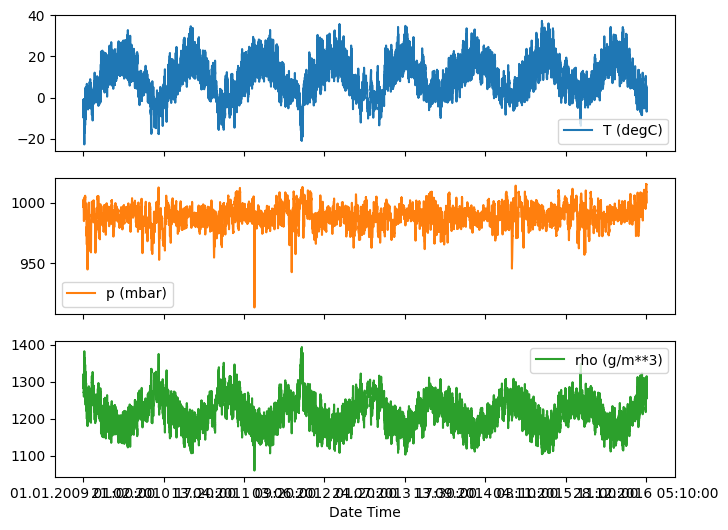

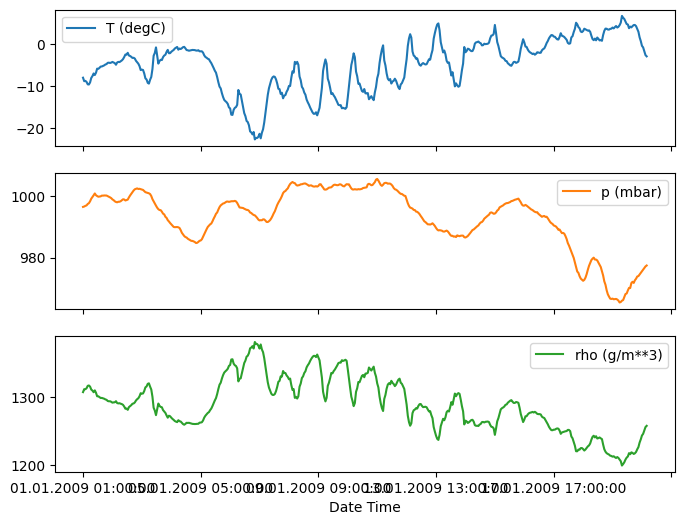

In [81]:
# plotting the evolution of features over time
plot_cols=['T (degC)','p (mbar)','rho (g/m**3)']

plot_features=df[plot_cols]
plot_features.index=date_time
_=plot_features.plot(subplots=True)

plot_features=df[plot_cols][:480]
plot_features.index=date_time[:480]
_=plot_features.plot(subplots=True)

Inspect and Cleanup

In [82]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


Window Velocity

In [83]:
wv=df['wv (m/s)']
bad_wv=wv==-9999.0
wv[bad_wv]=0.0

max_wv=df['max. wv (m/s)']
bad_max_wv=max_wv==-9999.0
max_wv[bad_max_wv]=0.0

df['wv (m/s)'].min()

0.0

Feature engineering

Wind

Text(0, 0.5, 'Wind Velocity [m/s]')

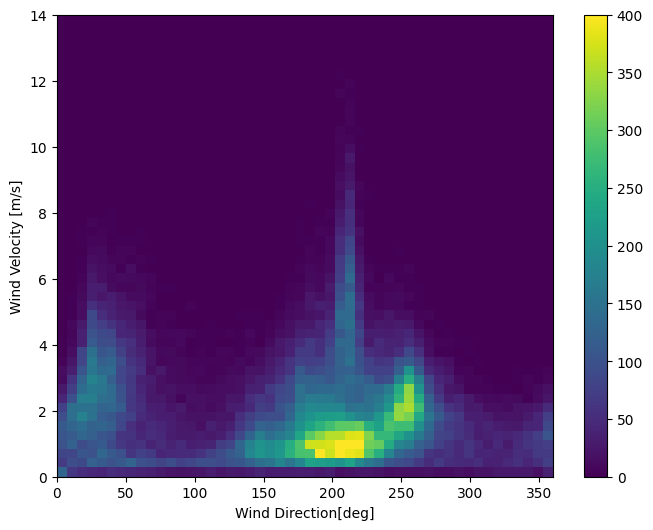

In [84]:
plt.hist2d(df['wd (deg)'],df['wv (m/s)'],bins=(50,50),vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction[deg]')
plt.ylabel('Wind Velocity [m/s]')

In [85]:
wv=df.pop('wv (m/s)')
max_wv=df.pop('max. wv (m/s)')

wd_rad=df.pop('wd (deg)')*np.pi/180

df['Wx']=wv*np.cos(wd_rad)
df['Wy']=wv*np.sin(wd_rad)

df['max Wx']=max_wv*np.cos(wd_rad)
df['max Wy']=max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

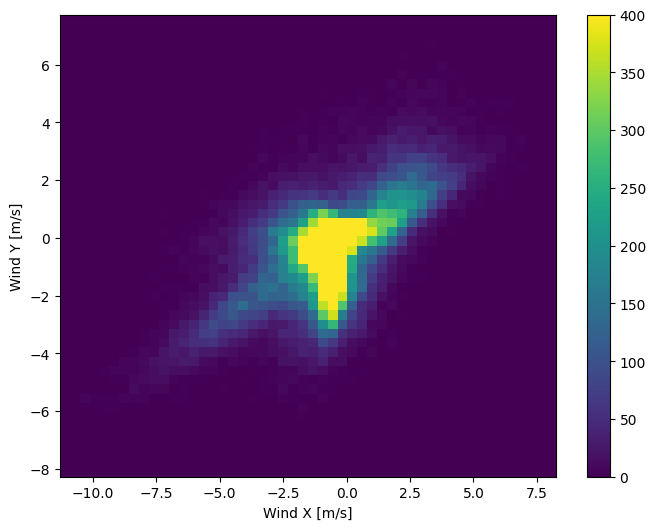

In [86]:
plt.hist2d(df['Wx'],df['Wy'],bins=(50,50),vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax=plt.gca()
ax.axis('tight')

Time

In [87]:
df.replace(np.nan, 0.0, inplace=True)
df.isnull().values.any()

False

In [88]:
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
timestamps_s=df['Date Time'].map(pd.Timestamp.timestamp)

In [89]:
df['Date Time'] = df['Date Time'].astype('int64') / 10**9

In [92]:
day=24*60*60
year=(365.2425)*day
df['Day sin'] = np.sin(timestamps_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamps_s * (2 * np.pi / day))

df['Year sin'] = np.sin(timestamps_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamps_s * (2 * np.pi / year))


Text(0.5, 1.0, 'Time of day signal')

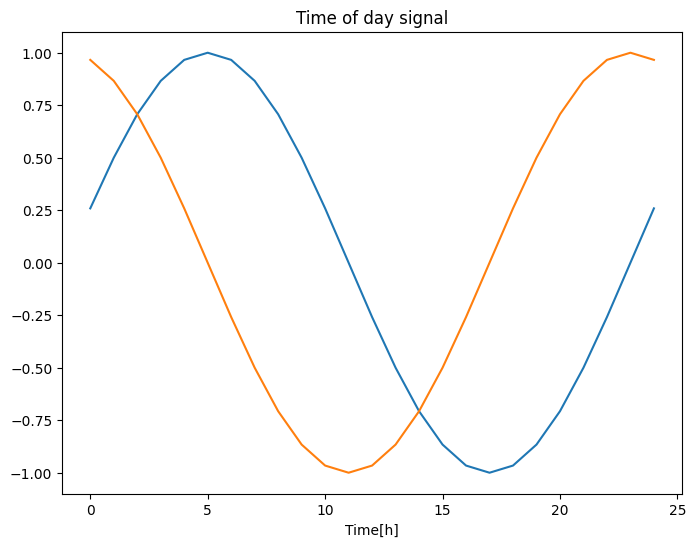

In [93]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])

plt.xlabel('Time[h]')
plt.title('Time of day signal')

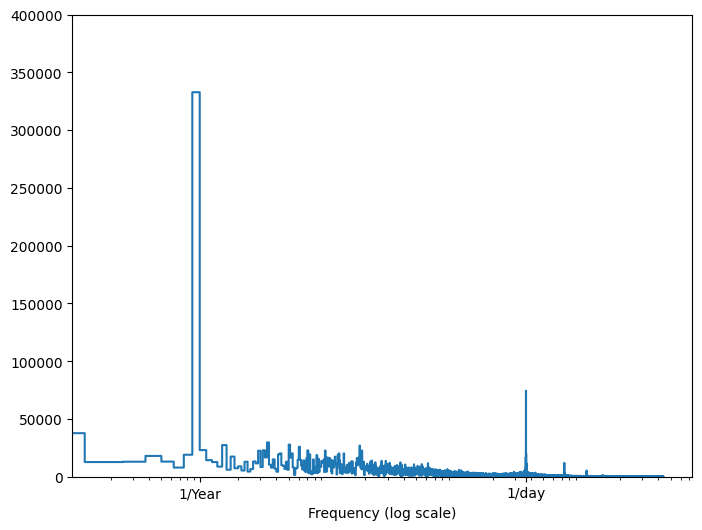

In [94]:
#inorder to find important freq features
fft=tf.signal.rfft(df['T (degC)'])
f_per_dataset=np.arange(0,len(fft))

n_samples_h=len(df['T (degC)'])
hours_per_year=24*365.2524
years_per_dataset=n_samples_h/(hours_per_year)

f_per_year=f_per_dataset/years_per_dataset
plt.step(f_per_year,np.abs(fft))
plt.xscale('log')
plt.ylim(0,400000)
plt.xlim([0.1,max(plt.xlim())])
plt.xticks([1,365.2524],labels=['1/Year','1/day'])
_=plt.xlabel('Frequency (log scale)')

split the data

In [95]:
column_indices={name: i for i, name in enumerate(df.columns)}

n=len(df)
train_df=df[0:int(n*0.7)]
val_df=df[int(n*0.7):int(n*0.9)]
test_df=df[int(n*0.9):]

num_features=df.shape[1]

In [96]:
train_df.isnull().values.any()

False

normalize the data

In [97]:
train_df.dtypes

,0
Date Time,float64
p (mbar),float64
T (degC),float64
Tpot (K),float64
Tdew (degC),float64
rh (%),float64
VPmax (mbar),float64
VPact (mbar),float64
VPdef (mbar),float64
sh (g/kg),float64


In [98]:
df.replace(np.nan, 0.0, inplace=True)
df.isnull().values.any()

False

In [99]:
train_df.isnull().values.any()

False

Normalize the data

In [100]:
numeric_columns = train_df.select_dtypes(include=['float64', 'int64']).columns

train_mean = train_df[numeric_columns].mean()
train_std = train_df[numeric_columns].std()

train_df[numeric_columns] = (train_df[numeric_columns] - train_mean) / train_std
val_df[numeric_columns] = (val_df[numeric_columns] - train_mean) / train_std
test_df[numeric_columns] = (test_df[numeric_columns] - train_mean) / train_std


<ipython-input-100-bcde2dbfa954>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[numeric_columns] = (train_df[numeric_columns] - train_mean) / train_std
<ipython-input-100-bcde2dbfa954>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[numeric_columns] = (val_df[numeric_columns] - train_mean) / train_std
<ipython-input-100-bcde2dbfa954>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [101]:
# train_df.replace(np.nan, 0.0, inplace=True)
test_df.isnull().values.any()

False

In [102]:
df.dtypes

,0
Date Time,float64
p (mbar),float64
T (degC),float64
Tpot (K),float64
Tdew (degC),float64
rh (%),float64
VPmax (mbar),float64
VPact (mbar),float64
VPdef (mbar),float64
sh (g/kg),float64


In [103]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Perform the normalization only on numeric columns
df_std = (df[numeric_cols] - train_mean) / train_std

<ipython-input-104-beb754300834>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _=ax.set_xticklabels(df.keys(),rotation=90)


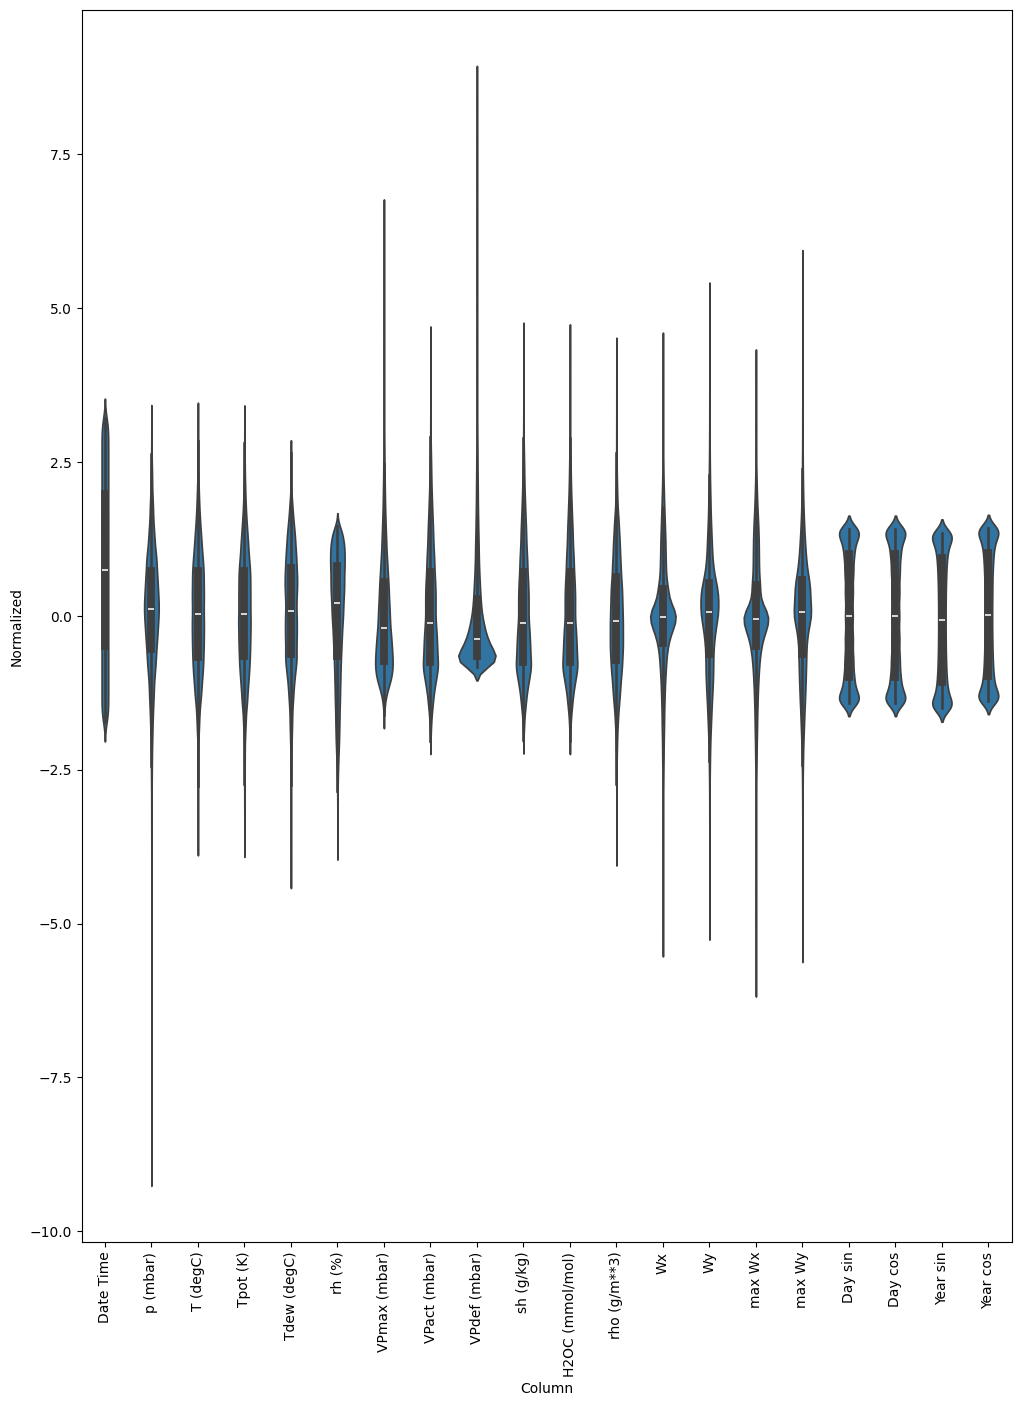

In [104]:
df_std=df_std.melt(var_name='Column',value_name='Normalized')
plt.figure(figsize=(12,16))
ax=sns.violinplot(x='Column',y='Normalized',data=df_std)
_=ax.set_xticklabels(df.keys(),rotation=90)

Data windowing

1.Indexes and offsets

In [105]:
class WindowGenerator:
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
        # Store raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Workout the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Workout the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        # Define slices and indices
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])



In [106]:
#to create a window
w1=WindowGenerator(input_width=24,
                   label_width=1,
                   shift=24,label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [107]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

2.Split

In [108]:
def split_window(self,features):
  inputs= features[:,self.input_slice,:]
  labels=features[:,self.labels_slice,:]

  if self.label_columns is not None:
    labels= tf.stack(
        [
            labels[:,:,self.column_indices[name]]for name in self.label_columns],axis=-1
    )
  inputs.set_shape([None,self.input_width,None])
  labels.set_shape([None,self.label_width,None])

  return inputs,labels
WindowGenerator.split_window=split_window


In [109]:
train_df = train_df[numeric_columns].to_numpy()

example_window = tf.stack([
    train_df[:w2.total_window_size],
    train_df[100:100+w2.total_window_size],
    train_df[200:200+w2.total_window_size]
])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 7, 20)
Inputs shape: (3, 6, 20)
Labels shape: (3, 1, 1)


3.Plot

In [110]:
w2.example=example_inputs,example_labels

In [111]:
def plot(self, model=None , plot_col='T (degC)',max_subplots=3):
  inputs,labels=self.example
  plt.figure(figsize=(12,8))
  plot_col_index=self.column_indices[plot_col]
  max_n=min(max_subplots,len(inputs))
  for n in range(max_n):
    plt.subplot(max_n,1,n+1)
    plt.ylabel(f'{plot_col}[normed]')
    plt.plot(self.input_indices,inputs[n,:,plot_col_index],
             label='Inputs',marker='.',zorder=-10)
    if self.label_columns:
      label_col_index=self.label_columns_indices.get(plot_col,None)
    else:
      label_col_index=plot_col_index
    if label_col_index is None:
      continue
    plt.scatter(self.label_indices,labels[n,:,label_col_index],edgecolors='k',label='Labels',c='#2ca02c',s=64)
    if model is not None:
      predictions=model(inputs)
      plt.scatter(self.label_indices,predictions[n,:,label_col_index],marker='X',edgecolors='k',label='Predictions',c='#ff7f0e',s=64)
    if n==0:
      plt.legend()
  plt.xlabel('Time[h]')
WindowGenerator.plot=plot

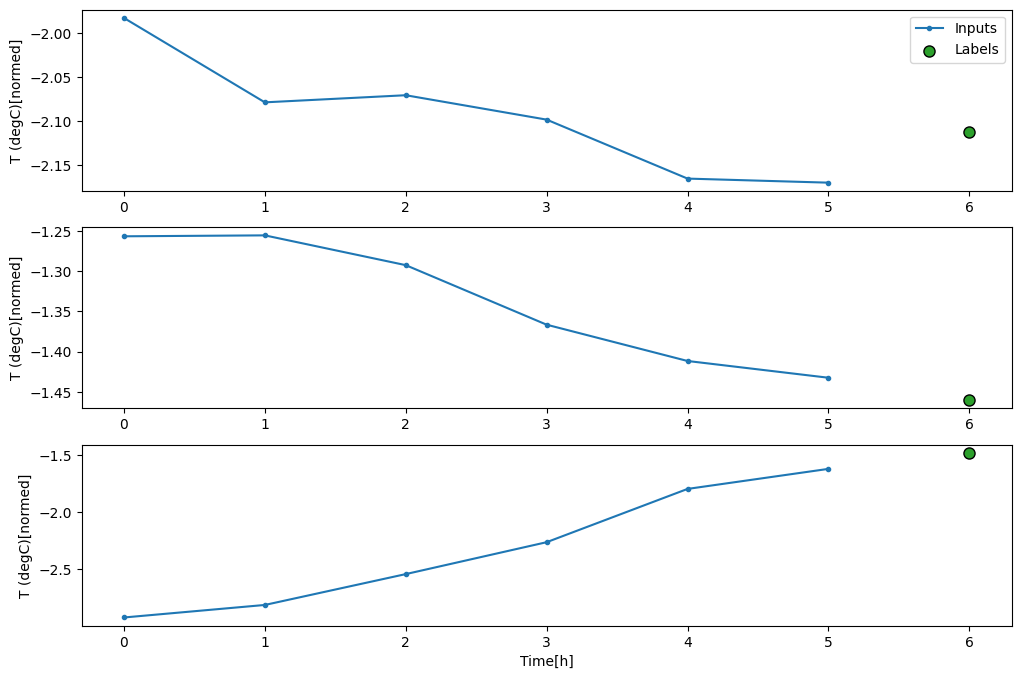

In [112]:
w2.plot()

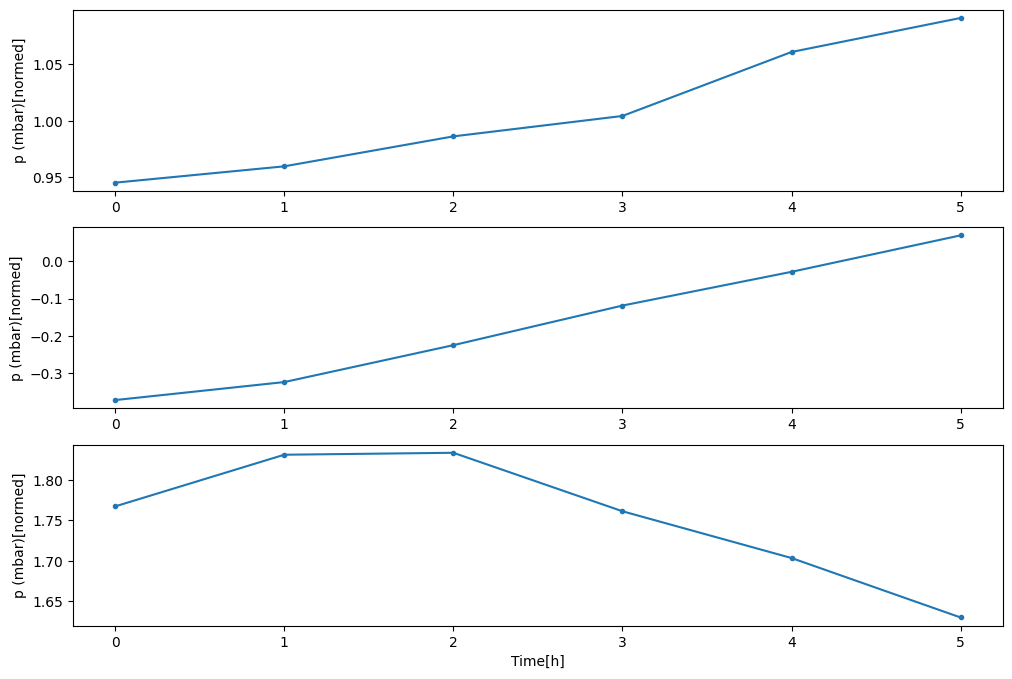

In [113]:
#plotting other columns
w2.plot(plot_col='p (mbar)')

Create tf.data.Datasets

In [114]:
def make_dataset(self,data):
  data=np.array(data,dtype=np.float32)
  ds=tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32
  )
  ds=ds.map(self.split_window)
  return ds
WindowGenerator.make_dataset=make_dataset

In [115]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  result=getattr(self,'_example',None)
  if result is None:
    result=next(iter(self.train))
    self._example=result
  return result

WindowGenerator.train=train
WindowGenerator.val=val
WindowGenerator.test=test
WindowGenerator.example=example

In [116]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 20), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [117]:
for example_inputs,example_labels in w2.train.take(1):
  print(f'Inputs shape (batch,time,features):{example_inputs.shape}')
  print(f'Labels shape(batch,time,features):{example_labels.shape}')

Inputs shape (batch,time,features):(32, 6, 20)
Labels shape(batch,time,features):(32, 1, 1)


single step models

In [118]:
single_step_window=WindowGenerator(
    input_width=1,label_columns=['T (degC)'],label_width=1,shift=1
)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [119]:
for example_inputs,example_labels in single_step_window.train.take(1):
  print(f'Input shape (batch,time,features):{example_inputs.shape}')
  print(f'Labels shape(batch,time,features):{example_labels.shape}')

Input shape (batch,time,features):(32, 1, 20)
Labels shape(batch,time,features):(32, 1, 1)


baseline

In [120]:
class Baseline(tf.keras.Model):
  def __init__(self,label_index=None):
    super().__init__()
    self.label_index=label_index
  def call(self,inputs):
    if self.label_index is None:
      return inputs
    result=inputs[:,:,self.label_index]
    return result[:,:,tf.newaxis]

In [121]:
#to evaluate this model
baseline=Baseline(label_index=column_indices['T (degC)'])
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.MeanAbsoluteError()])
val_performance={}
performance={}
val_performance['Baseline']=baseline.evaluate(single_step_window.val,return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

439/439 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0123 - mean_absolute_error: 0.0776


In [122]:
wide_window=WindowGenerator(input_width =24, label_width=24,shift=1,label_columns=['T (degC)'])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [123]:
print('Input shape:',wide_window.example[0].shape)
output=baseline(wide_window.example[0])
print('Output shape:',output.shape)


Input shape: (32, 24, 20)
Output shape: (32, 24, 1)


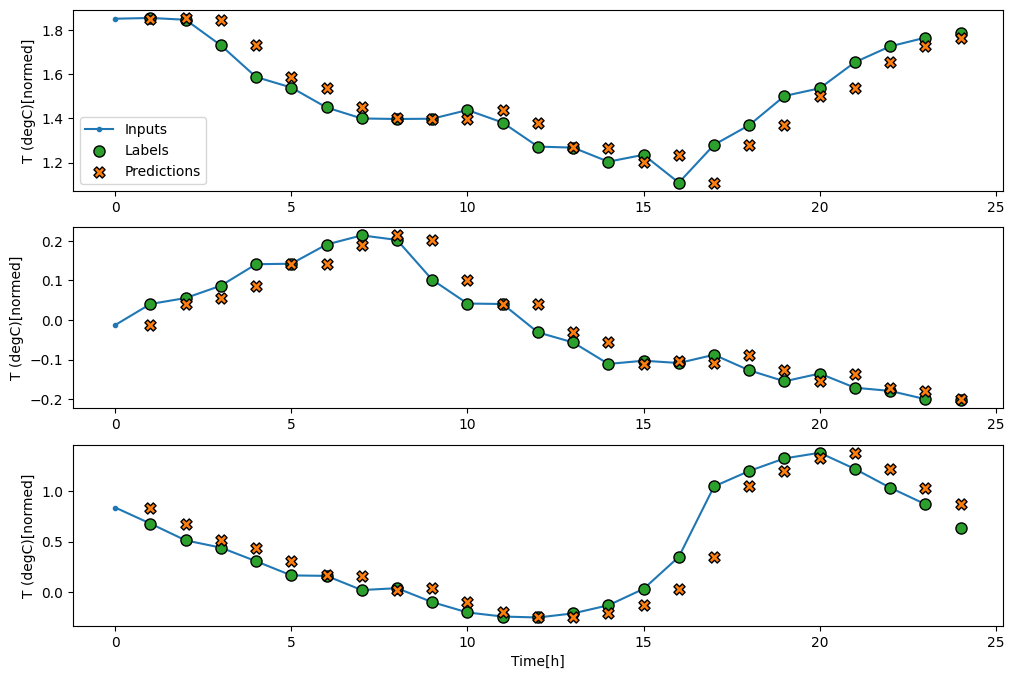

In [124]:
wide_window.plot(baseline)

Linear

In [125]:
linear=tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

In [126]:
print('Input shape:',single_step_window.example[0].shape)
output=linear(single_step_window.example[0])
print('Output shape:',output.shape)

Input shape: (32, 1, 20)
Output shape: (32, 1, 1)


In [127]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 20)
Output shape: (32, 24, 1)


In [128]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history



In [129]:
print(single_step_window)

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']


In [130]:
df.isnull().values.any()

False

In [131]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.1577 - mean_absolute_error: 0.2715 - val_loss: 0.0091 - val_mean_absolute_error: 0.0708
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0092 - mean_absolute_error: 0.0706 - val_loss: 0.0088 - val_mean_absolute_error: 0.0694
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0091 - mean_absolute_error: 0.0698 - val_loss: 0.0088 - val_mean_absolute_error: 0.0695
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0091 - mean_absolute_error: 0.0699 - val_loss: 0.0089 - val_mean_absolute_error: 0.0697
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087 - mean_absolute_error: 0.0690


In [132]:
print('Input shape:', wide_window.example[0].shape)

output=linear(wide_window.example[0])
print('Output shape:', output.shape)

Input shape: (32, 24, 20)
Output shape: (32, 24, 1)


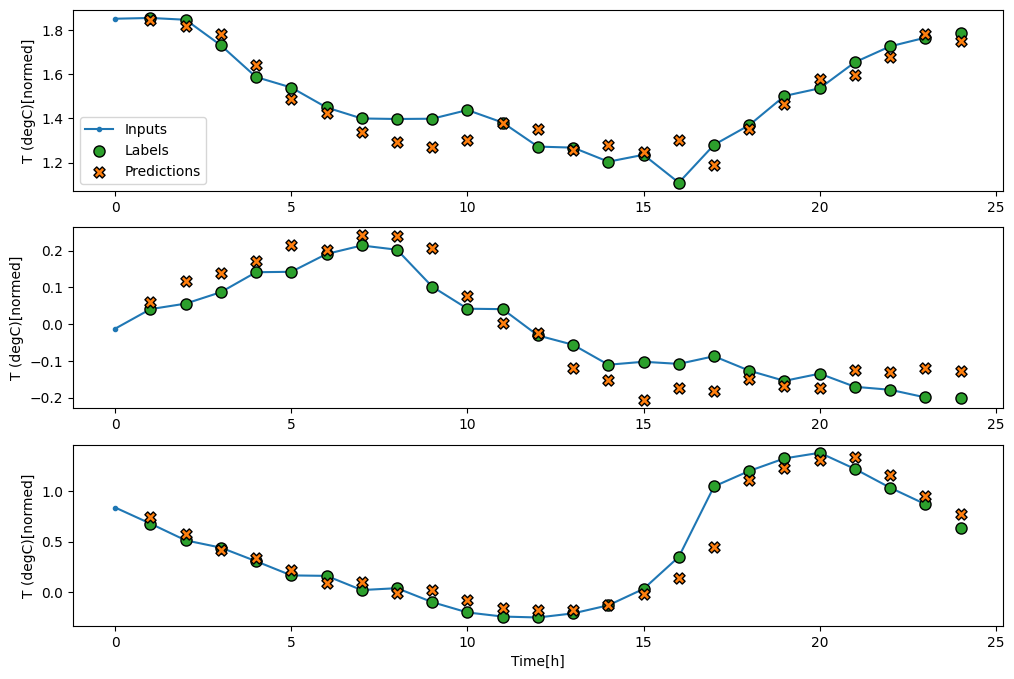

In [133]:
wide_window.plot(linear)

In [134]:
print(train_df)

[[-1.73202173  0.9453076  -1.98247323 ...  1.3660688  -0.06105236
   1.42843408]
 [-1.73195107  0.95976985 -2.07837211 ...  1.22479437 -0.06002935
   1.42842359]
 [-1.73188041  0.98628397 -2.07028426 ...  1.00005921 -0.05900635
   1.42841238]
 ...
 [ 1.73080506  0.21737449  0.74082386 ...  1.38073381 -0.85673935
  -1.15351058]
 [ 1.73087573  0.21375893  0.71078325 ...  1.41290891 -0.85759531
  -1.15295871]
 [ 1.73094639  0.16675662  0.65301284 ...  1.34880358 -0.85845086
  -1.15240624]]


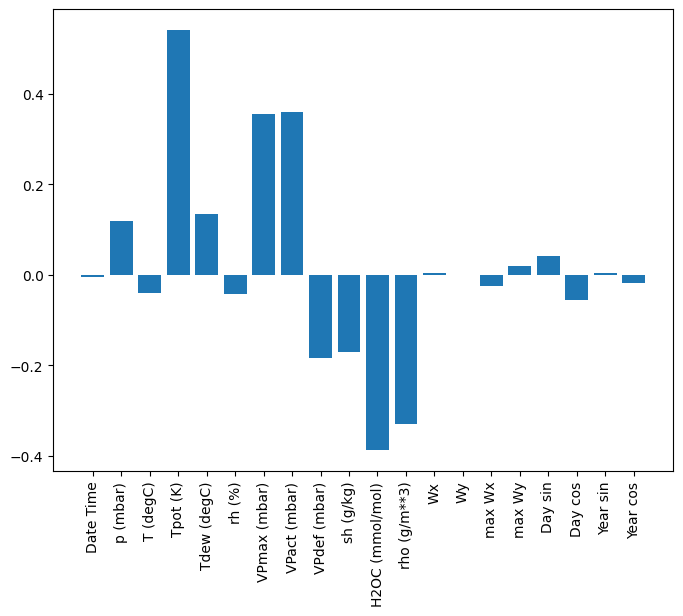

In [135]:
plt.bar(x = range(len(df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(df.columns)))
_ = axis.set_xticklabels(df.columns, rotation=90)

Dense

In [136]:
dense=tf.keras.Sequential([
    tf.keras.layers.Dense(units=64,activation='relu'),
    tf.keras.layers.Dense(units=64,activation='relu'),
    tf.keras.layers.Dense(units=1)
])
history=compile_and_fit(dense,single_step_window)

val_performance['Dense']=dense.evaluate(single_step_window.val,return_dict=True)
performance['Dense']=dense.evaluate(single_step_window.test,verbose=0,return_dict=True)

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0629 - mean_absolute_error: 0.1294 - val_loss: 0.0095 - val_mean_absolute_error: 0.0734
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0081 - mean_absolute_error: 0.0652 - val_loss: 0.0081 - val_mean_absolute_error: 0.0665
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0074 - mean_absolute_error: 0.0619 - val_loss: 0.0081 - val_mean_absolute_error: 0.0668
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0074 - mean_absolute_error: 0.0616 - val_loss: 0.0084 - val_mean_absolute_error: 0.0678
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0082 - mean_absolute_error: 0.0676


Multi-step Dense

In [137]:
CONV_WIDTH=3
conv_window=WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)']
)
conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 0.98, 'Given 3 hours of inputs , predict 1 hour into the future')

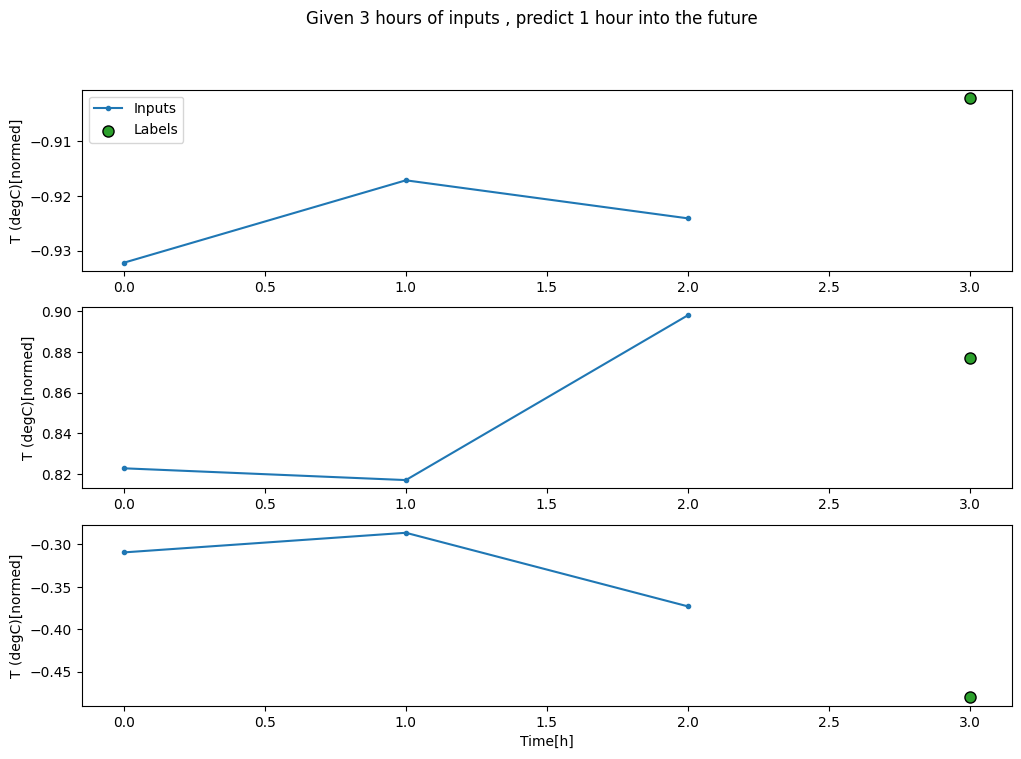

In [138]:
conv_window.plot()
plt.suptitle("Given 3 hours of inputs , predict 1 hour into the future")

In [139]:
multi_step_dense=tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32,activation='relu'),
    tf.keras.layers.Dense(units=32,activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1,-1])
])

In [140]:
print('Input shape:',conv_window.example[0].shape)
print('Output shape:',multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 20)
Output shape: (32, 1, 1)


In [141]:
history=compile_and_fit(multi_step_dense,conv_window)

IPython.display.clear_output()
val_performance['Multi step dense']=multi_step_dense.evaluate(conv_window.val,return_dict=True)
performance['Multi step dense']=multi_step_dense.evaluate(conv_window.test,verbose=0,return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0071 - mean_absolute_error: 0.0608


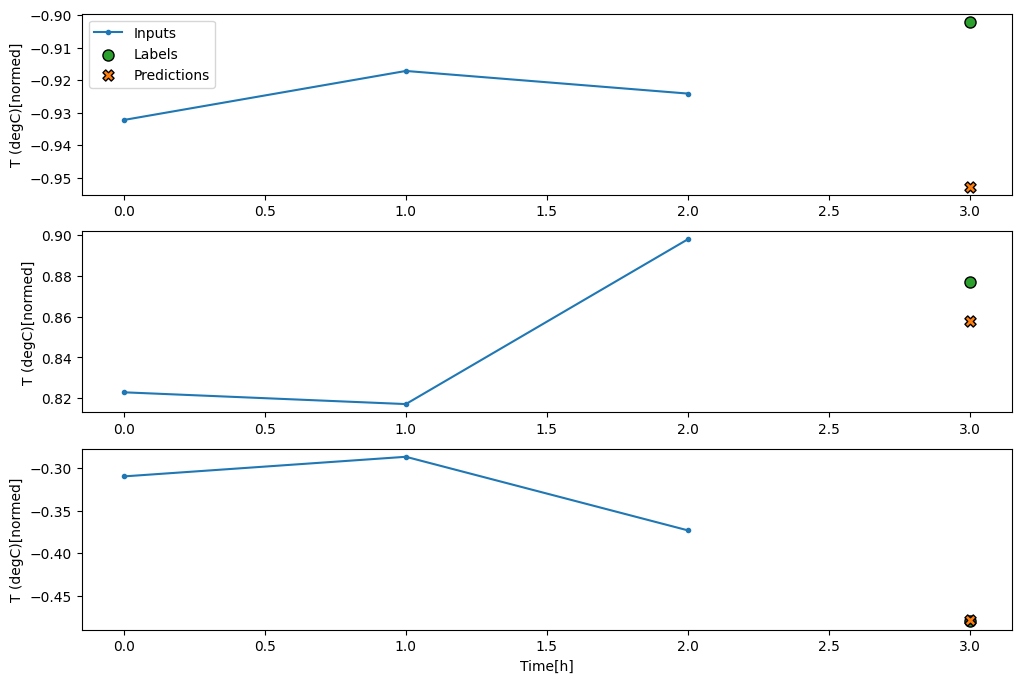

In [142]:
conv_window.plot(multi_step_dense)

Convolution Neural Network

In [143]:
conv_model=tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32,activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [144]:
print("Conv model on 'conv_window'")
print('Input shape:',conv_window.example[0].shape)
print('Output shape:',conv_model(conv_window.example[0]).shape)

Conv model on 'conv_window'
Input shape: (32, 3, 20)
Output shape: (32, 1, 1)


In [145]:
history=compile_and_fit(conv_model,conv_window)
IPython.display.clear_output()
val_performance['Conv']=conv_model.evaluate(conv_window.val,return_dict=True)
performance['Conv']=conv_model.evaluate(conv_window.test,verbose=0,return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0068 - mean_absolute_error: 0.0600


In [146]:
print('Wide Window')
print('Input shape:',wide_window.example[0].shape)
print('Label shape:',wide_window.example[1].shape)
print('Output shape:',conv_model(wide_window.example[0]).shape)

Wide Window
Input shape: (32, 24, 20)
Label shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [147]:
LABEL_WIDTH=24
INPUT_WIDTH=LABEL_WIDTH+(CONV_WIDTH-1)
wide_conv_window=WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)']
)
wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [148]:
print('Wide Window')
print('Input shape:',wide_window.example[0].shape)
print('Label shape:',wide_window.example[1].shape)
print('Output shape:',conv_model(wide_window.example[0]).shape)

Wide Window
Input shape: (32, 24, 20)
Label shape: (32, 24, 1)
Output shape: (32, 22, 1)


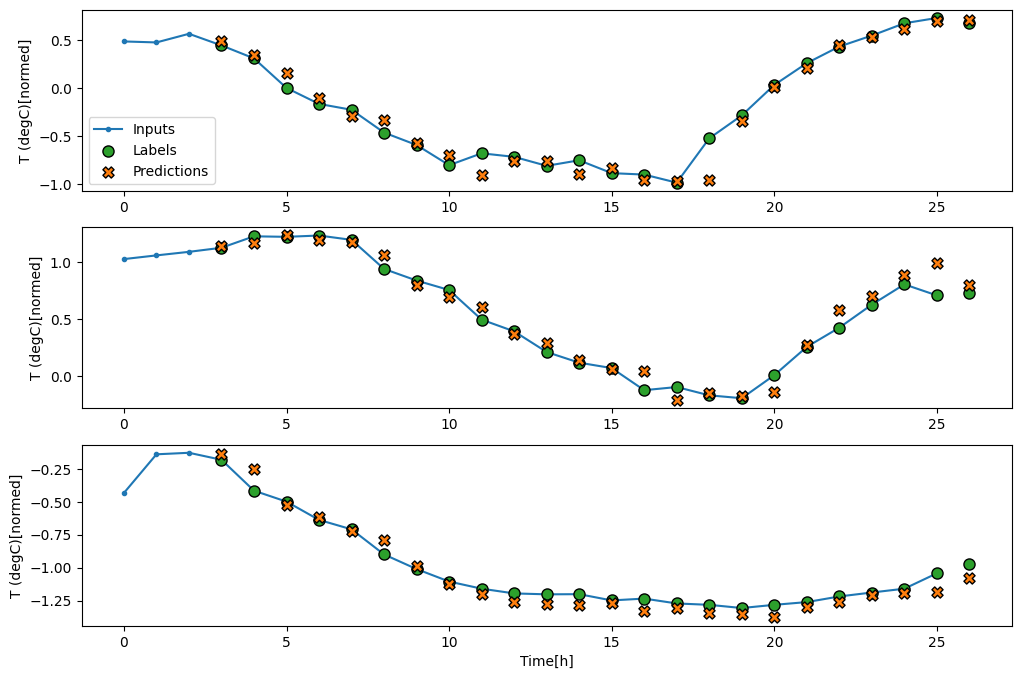

In [149]:
wide_conv_window.plot(conv_model)

Recurrent Neural Network

In [150]:
lstm_model=tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32,return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [151]:
print('Input shape:',wide_window.example[0].shape)
print('Output shape:',lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 20)
Output shape: (32, 24, 1)


In [152]:
history=compile_and_fit(lstm_model,wide_window)
IPython.display.clear_output()

val_performance['LSTM']=lstm_model.evaluate(wide_window.val,return_dict=True)
performance['LSTM']=lstm_model.evaluate(wide_window.test,verbose=0,return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0058 - mean_absolute_error: 0.0527


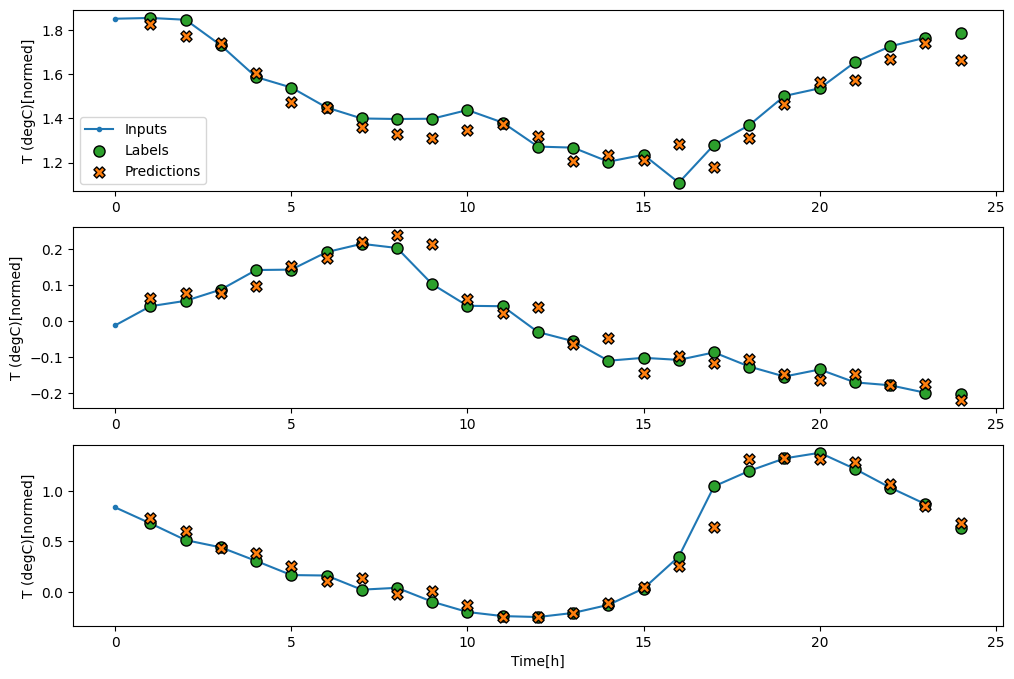

In [153]:
wide_window.plot(lstm_model)

Performance

In [154]:
cm=lstm_model.metrics[1]
cm.metrics

[<MeanAbsoluteError name=mean_absolute_error>]

In [155]:
val_performance

{'Baseline': {'loss': 0.012845631688833237,
  'mean_absolute_error': 0.07846628874540329},
 'Linear': {'loss': 0.008890160359442234,
  'mean_absolute_error': 0.06971342116594315},
 'Dense': {'loss': 0.008381206542253494,
  'mean_absolute_error': 0.06777472794055939},
 'Multi step dense': {'loss': 0.0071378289721906185,
  'mean_absolute_error': 0.06050929054617882},
 'Conv': {'loss': 0.0070206462405622005,
  'mean_absolute_error': 0.060397956520318985},
 'LSTM': {'loss': 0.00575217604637146,
  'mean_absolute_error': 0.05259125679731369}}

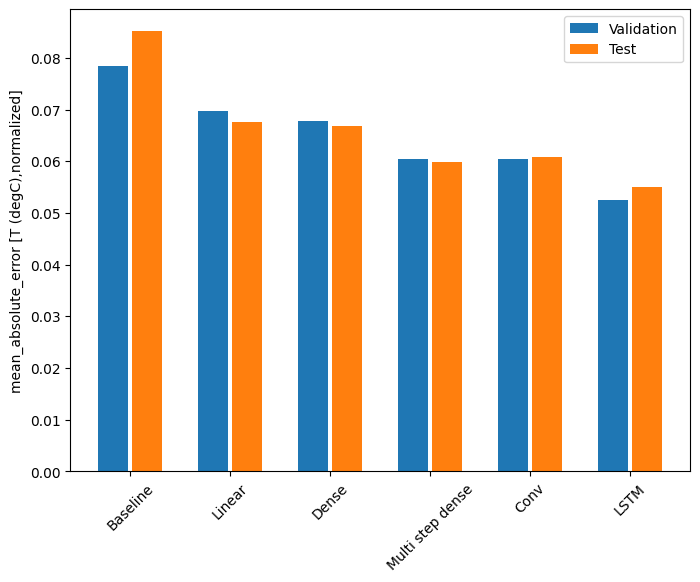

In [156]:
x=np.arange(len(performance))
width=0.3
metric_name='mean_absolute_error'
val_mae=[v[metric_name]for v in val_performance.values()]
test_mae=[v[metric_name]for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC),normalized]')
plt.bar(x-0.17,val_mae,width,label='Validation')
plt.bar(x+0.17,test_mae,width,label='Test')
plt.xticks(ticks=x,labels=performance.keys(),rotation=45)
_=plt.legend()

In [157]:
for name, value in performance.items():
  print(f'{name:12s}:{value[metric_name]:0.4f}')

Baseline    :0.0852
Linear      :0.0675
Dense       :0.0668
Multi step dense:0.0599
Conv        :0.0609
LSTM        :0.0551


Multi output models

In [158]:
single_step_window=WindowGenerator(input_width=1,label_width=1,shift=1)
wide_window=WindowGenerator(input_width=24,label_width=24,shift=1)
for example_inputs,example_labels in wide_window.train.take(1):
  print(f'Input shape(batch,time,features):{example_inputs.shape}')
  print(f'Labels shape (batch,time,features):{example_labels.shape}')

Input shape(batch,time,features):(32, 24, 20)
Labels shape (batch,time,features):(32, 24, 20)


Baseline

In [159]:
baseline=Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [160]:
val_performance={}
performance={}
val_performance['Baseline']=baseline.evaluate(wide_window.val,return_dict=True)
performance['Baseline']=baseline.evaluate(wide_window.test,verbose=0,return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0837 - mean_absolute_error: 0.1507


Dense

In [161]:
dense=tf.keras.Sequential([
    tf.keras.layers.Dense(units=64,activation='relu'),
    tf.keras.layers.Dense(units=64,activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [162]:
history=compile_and_fit(dense,single_step_window)
IPython.display.clear_output()
val_performance['Dense']=dense.evaluate(single_step_window.val,return_dict=True)
performance['Dense']=dense.evaluate(single_step_window.test,verbose=0,return_dict=True)

439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0659 - mean_absolute_error: 0.1276


RNN

In [163]:
%%time
wide_window=WindowGenerator(
    input_width=24,label_width=24,shift=1
)
lstm_model=tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32,return_sequences=True),
    tf.keras.layers.Dense(units=num_features)
])
history=compile_and_fit(lstm_model,wide_window)
IPython.display.clear_output()
val_performance['LSTM']=lstm_model.evaluate(wide_window.val,return_dict=True)
performance['LSTM']=lstm_model.evaluate(wide_window.test,verbose=0,return_dict=True)

print()

438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0598 - mean_absolute_error: 0.1190

CPU times: user 8min 1s, sys: 32.8 s, total: 8min 34s
Wall time: 7min 10s


Advanced:Residual Connections

In [164]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        return inputs + delta


In [165]:
from IPython.display import clear_output

residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(
            num_features,
            kernel_initializer=tf.initializers.zeros()
        )
    ])
)

history = compile_and_fit(residual_lstm, wide_window)

clear_output()

val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)

print()


438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0601 - mean_absolute_error: 0.1134



Performance

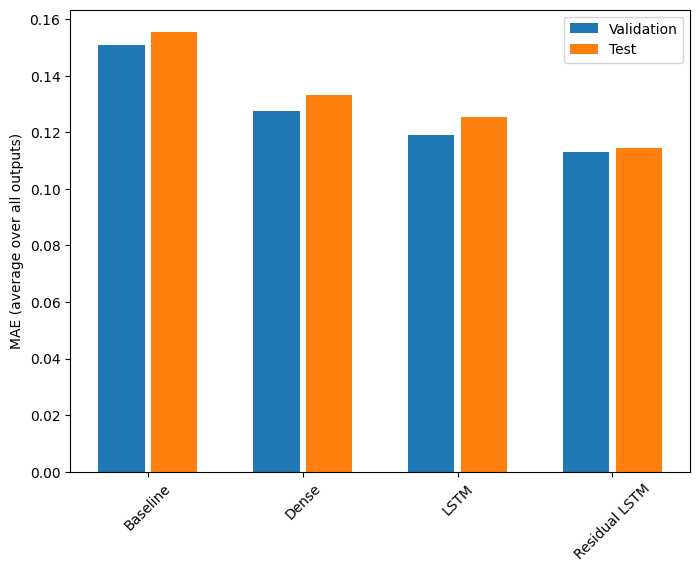

In [166]:
x=np.arange(len(performance))
width=0.3

metric_name='mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()


In [167]:
for name, value in performance.items():
  print(f'{name:15s}: {value[metric_name]:0.4f}')

Baseline       : 0.1556
Dense          : 0.1331
LSTM           : 0.1252
Residual LSTM  : 0.1146


Multistep models

```
# This is formatted as code
```



Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

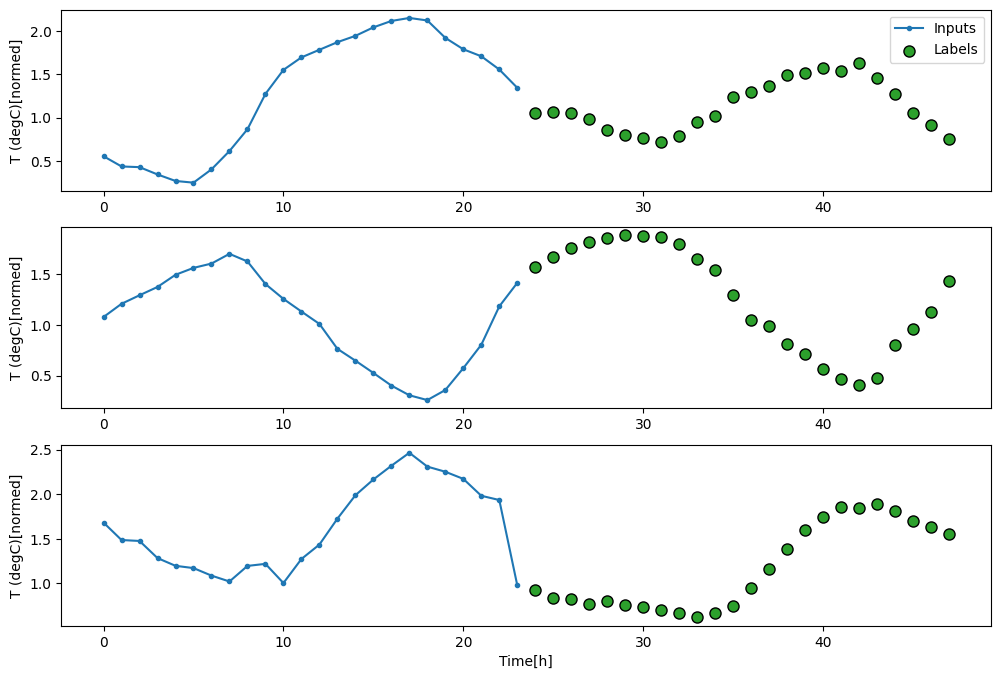

In [168]:
OUT_STEPS=24
multi_window = WindowGenerator(input_width=24,label_width=OUT_STEPS,shift=OUT_STEPS)
multi_window.plot()
multi_window

Baselines

437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.5962 - mean_absolute_error: 0.4753


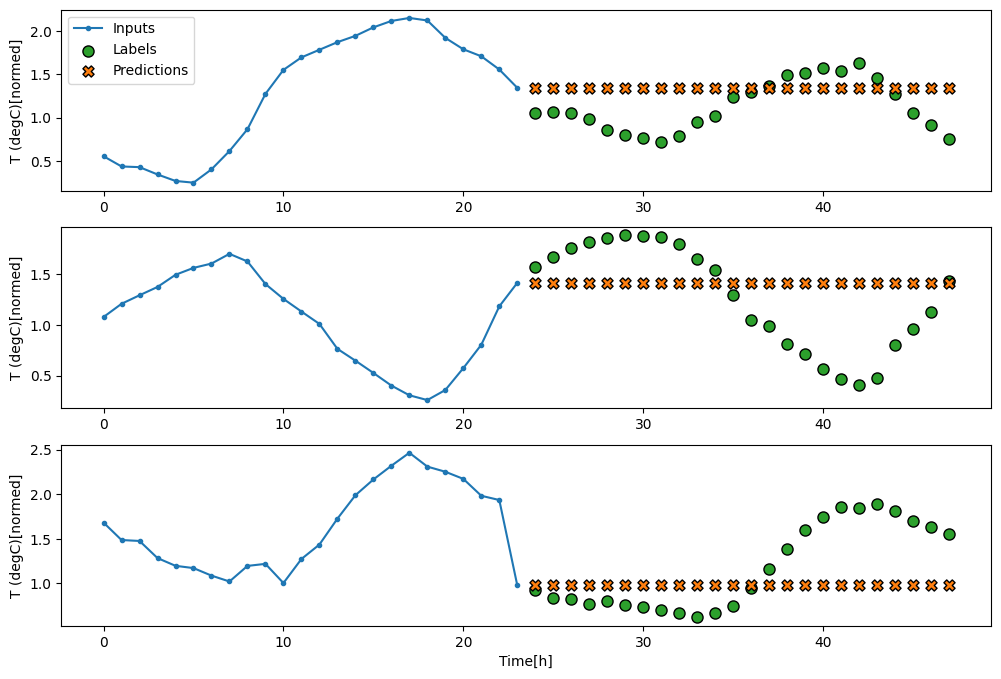

In [169]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self,inputs):
    return tf.tile(inputs[:,-1:,:],[1,OUT_STEPS,1])

last_baseline=MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.MeanAbsoluteError()])
multi_val_performance={}
multi_performance={}

multi_val_performance['Last']=last_baseline.evaluate(multi_window.val,return_dict=0)
multi_performance['Last']=last_baseline.evaluate(multi_window.test,verbose=0,return_dict=0)
multi_window.plot(last_baseline)


437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4066 - mean_absolute_error: 0.3756


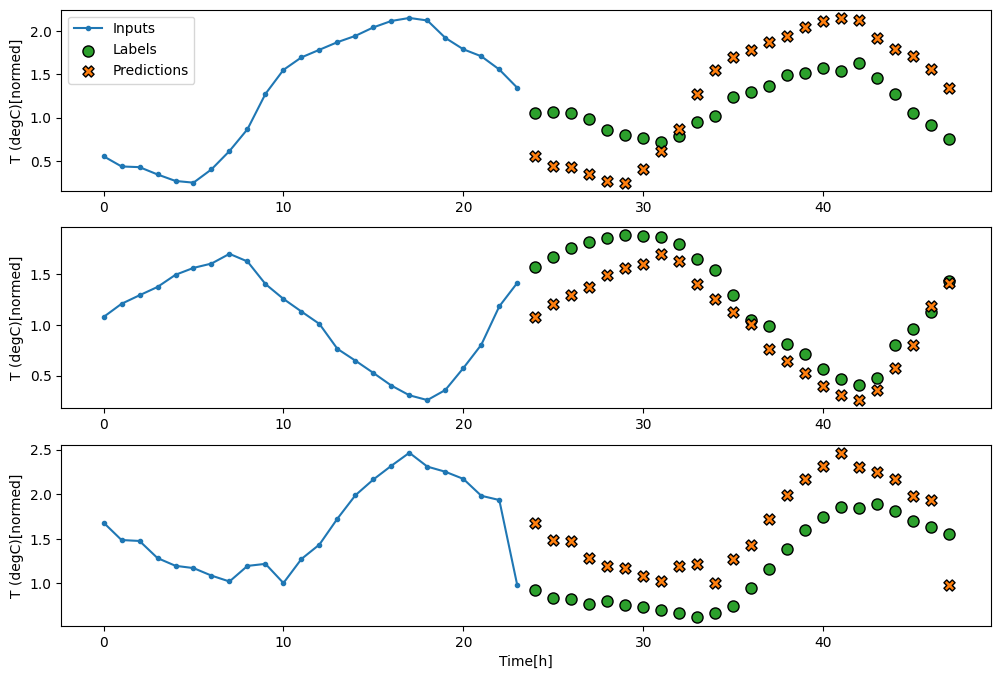

In [170]:
class RepeatBaseline(tf.keras.Model):
  def call(self,inputs):
    return inputs

repeat_baseline=RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat']=repeat_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Repeat']=repeat_baseline.evaluate(multi_window.test,verbose=0,return_dict=True)
multi_window.plot(repeat_baseline)

Single shot models

Linear

437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2448 - mean_absolute_error: 0.2908


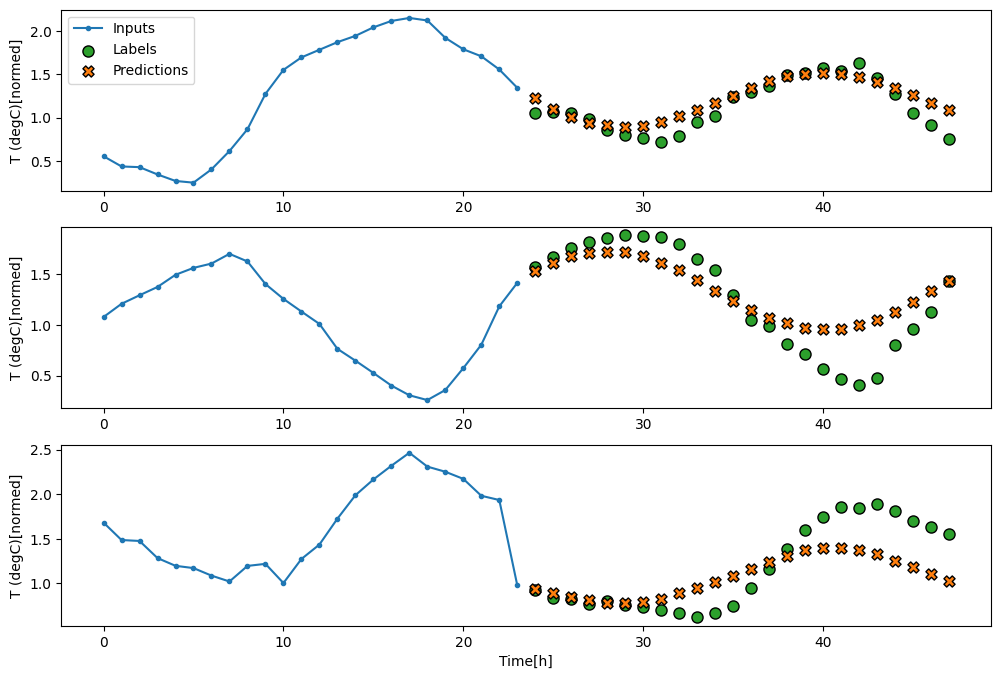

In [171]:
multi_linear_model=tf.keras.Sequential(
    [
        tf.keras.layers.Lambda(lambda x:x[:,-1:,:]),
        tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),
        tf.keras.layers.Reshape([OUT_STEPS,num_features])
    ]
)
history=compile_and_fit(multi_linear_model,multi_window)
IPython.display.clear_output()
multi_val_performance['Linear']=multi_linear_model.evaluate(multi_window.val,return_dict=True)
multi_performance['Linear']=multi_linear_model.evaluate(multi_window.test,verbose=0,return_dict=True)
multi_window.plot(multi_linear_model)

Dense

437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2299 - mean_absolute_error: 0.2865


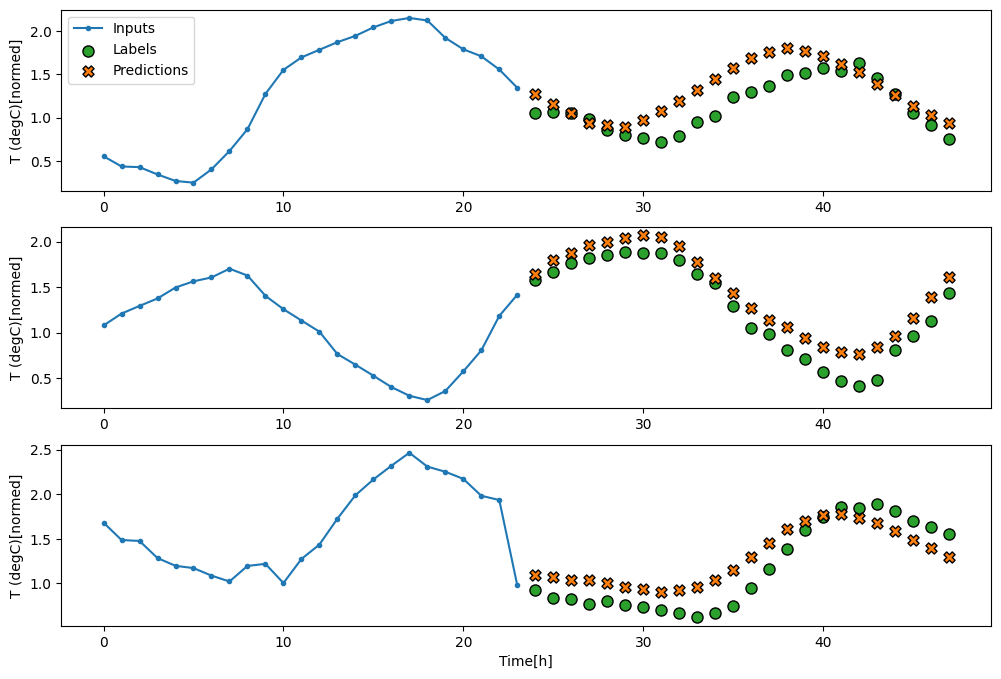

In [172]:
multi_dense_model=tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x:x[:,-1:,:]),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS,num_features])
])
history=compile_and_fit(multi_dense_model,multi_window)
IPython.display.clear_output()
multi_val_performance['Dense']=multi_dense_model.evaluate(multi_window.val,return_dict=True)
multi_performance['Dense']=multi_dense_model.evaluate(multi_window.test,verbose=0,return_dict=True)
multi_window.plot(multi_dense_model)

CNN

437/437 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2113 - mean_absolute_error: 0.2750


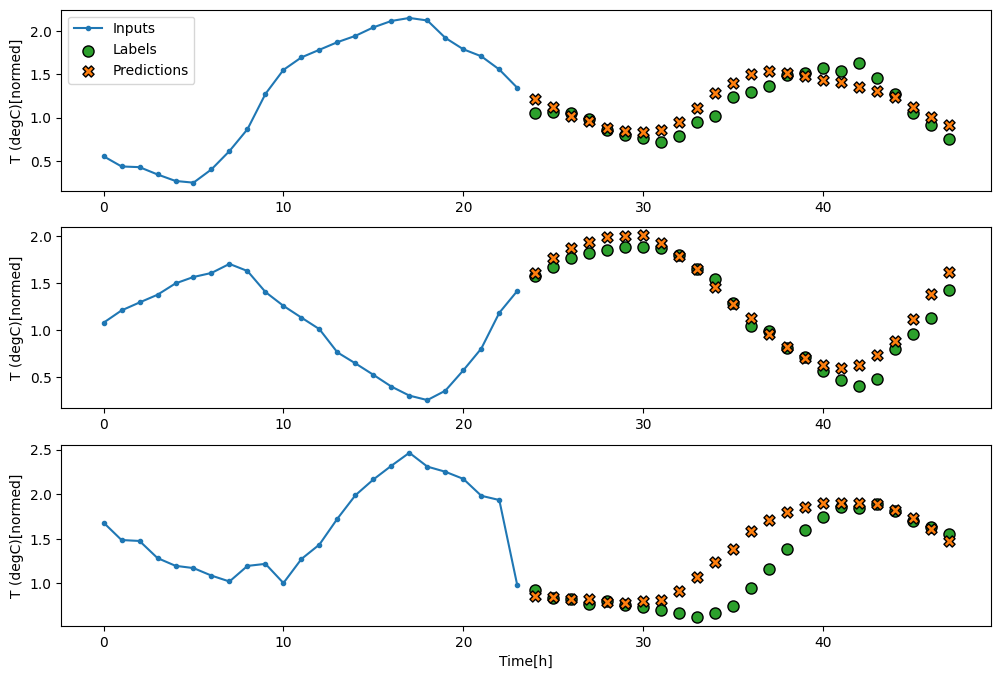

In [173]:
from IPython.display import clear_output
CONV_WIDTH=3
multi_conv_model=tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x:x [:,-CONV_WIDTH:,:]),
    tf.keras.layers.Conv1D(256,activation='relu',kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS,num_features])
])
history=compile_and_fit(multi_conv_model,multi_window)
clear_output()
multi_val_performance['Conv']=multi_conv_model.evaluate(multi_window.val,return_dict=True)
multi_performance['Conv']=multi_conv_model.evaluate(multi_window.test,verbose=0,return_dict=True)
multi_window.plot(multi_conv_model)

RNN

437/437 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2140 - mean_absolute_error: 0.2863


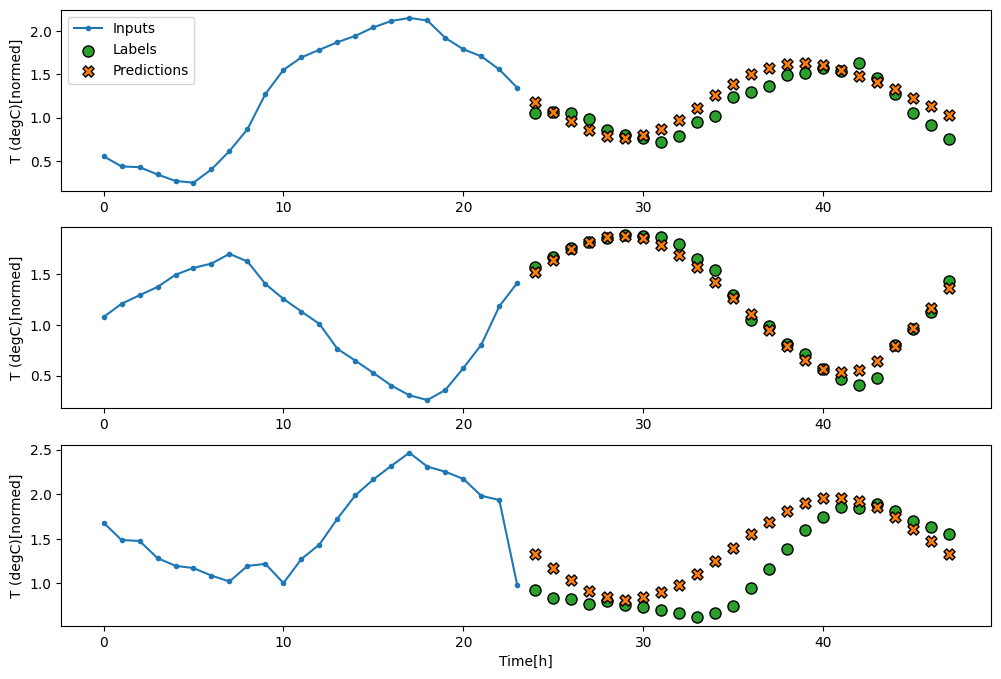

In [174]:
multi_lstm_model=tf.keras.Sequential([
    tf.keras.layers.LSTM(32,return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS,num_features])
])
history=compile_and_fit(multi_lstm_model,multi_window)
IPython.display.clear_output()
multi_val_performance['LSTM']=multi_lstm_model.evaluate(multi_window.val,return_dict=True)
multi_performance['LSTM']=multi_lstm_model.evaluate(multi_window.test,verbose=0,return_dict=True)
multi_window.plot(multi_lstm_model)

RNN with manual management of inputs

In [323]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps, num_features):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [324]:
def warmup(self,inputs):
  x, *state= self.lstm_rnn(inputs)
  prediction= self.dense(x)
  return prediction, state
FeedBack.warmup=warmup

In [325]:
def call(self, inputs, training=None):
  predictions= []
  prediction, state= self.warmup(inputs)
  predictions.append(prediction)

  for n in range(1, self.out_steps):
    x= prediction
    x,state= self.lstm_cell(x, states=state, training=training)
    prediction =self.dense(x)
    predictions.append(prediction)

  predictions= tf.stack(predictions,axis=1)
  predictions= tf.transpose(predictions,[0,1,2])
  return predictions
FeedBack.call=call

In [326]:
feedback_model=FeedBack(units=32,out_steps=OUT_STEPS,num_features=num_features)

In [327]:
prediction, state= feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 20])

In [328]:

print('Output shape (batch, time, features): ',feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 20)


In [329]:
#feedback_model.compile(optimizer='adam', loss='mse')

437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2390 - mean_absolute_error: 0.3210


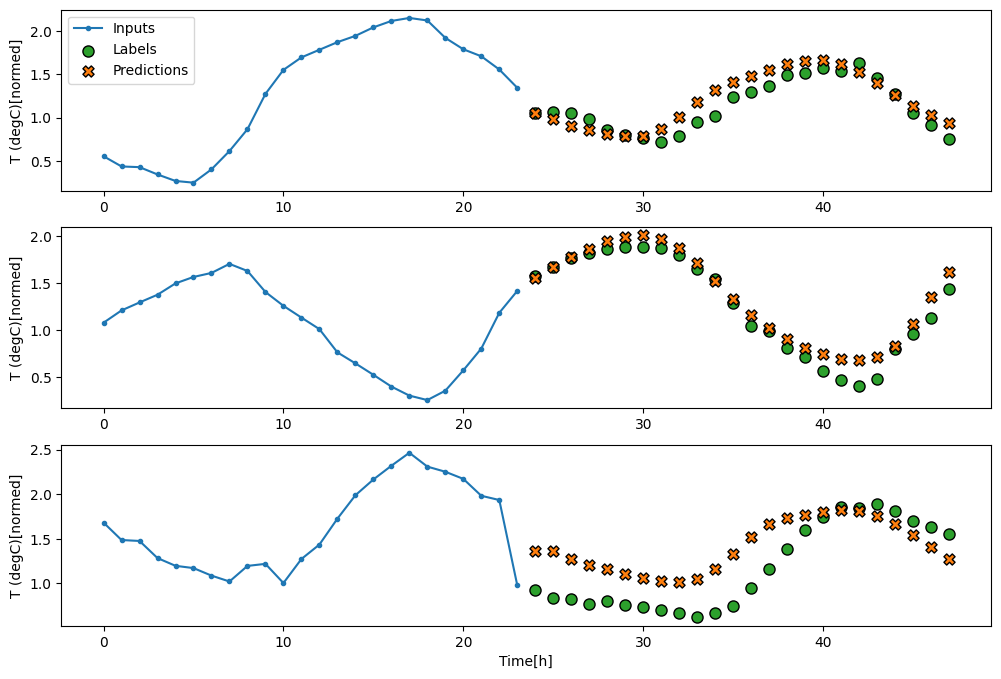

In [330]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)

Performance